<a href="https://colab.research.google.com/github/Shinjon-Ghosh/Deep_Learning_Project/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 123
LABELS = ["Normal", "Fraud"]

In [ ]:
from google.colab import files
cf = files.upload()



Saving creditcard.csv to creditcard.csv


In [ ]:
cf = pd.read_csv("creditcard.csv")

In [ ]:
cf.shape

(284807, 31)

In [ ]:
cf.isnull().values.any()

False

In [ ]:
frauds = cf[cf.Class == 1]
normal = cf[cf.Class == 0]
frauds.shape

(492, 31)

In [ ]:
normal.shape

(284315, 31)

In [ ]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [ ]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler

data = cf.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [ ]:
normal_train, normal_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
normal_train = normal_train[normal_train.Class == 0]
normal_train = normal_train.drop(['Class'], axis=1)

fraud_test = normal_test['Class']
normal_test = normal_test.drop(['Class'], axis=1)

normal_train = normal_train.values
normal_test = normal_test.values

In [ ]:
input_dim = normal_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 50
batch_size = 22

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(normal_train, normal_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(normal_test, normal_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
9047/9047 [==============================] - 36s 4ms/step - loss: 0.7792 - accuracy: 0.5801 - val_loss: 0.7631 - val_accuracy: 0.6588
Epoch 2/50
  50/9047 [..............................] - ETA: 18s - loss: 0.6356 - accuracy: 0.6736

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9047/9047 [==============================] - 29s 3ms/step - loss: 0.7174 - accuracy: 0.6724 - val_loss: 0.7385 - val_accuracy: 0.6831
Epoch 3/50
9047/9047 [==============================] - 32s 4ms/step - loss: 0.7033 - accuracy: 0.6886 - val_loss: 0.7319 - val_accuracy: 0.6914
Epoch 4/50
9047/9047 [==============================] - 31s 3ms/step - loss: 0.6979 - accuracy: 0.6943 - val_loss: 0.7270 - val_accuracy: 0.6949
Epoch 5/50
9047/9047 [==============================] - 28s 3ms/step - loss: 0.6949 - accuracy: 0.7001 - val_loss: 0.7275 - val_accuracy: 0.6978
Epoch 6/50
9047/9047 [==============================] - 28s 3ms/step - loss: 0.6922 - accuracy: 0.7056 - val_loss: 0.7229 - val_accuracy: 0.7128
Epoch 7/50
9047/9047 [==============================] - 32s 3ms/step - loss: 0.6892 - accuracy: 0.7110 - val_loss: 0.7187 - val_accuracy: 0.7191
Epoch 8/50
9047/9047 [==============================] - 34s 4ms/step - loss: 0.6874 - accuracy: 0.7145 - val_loss: 0.7174 - val_accuracy: 0.7

In [ ]:
autoencoder = load_model('model.h5')

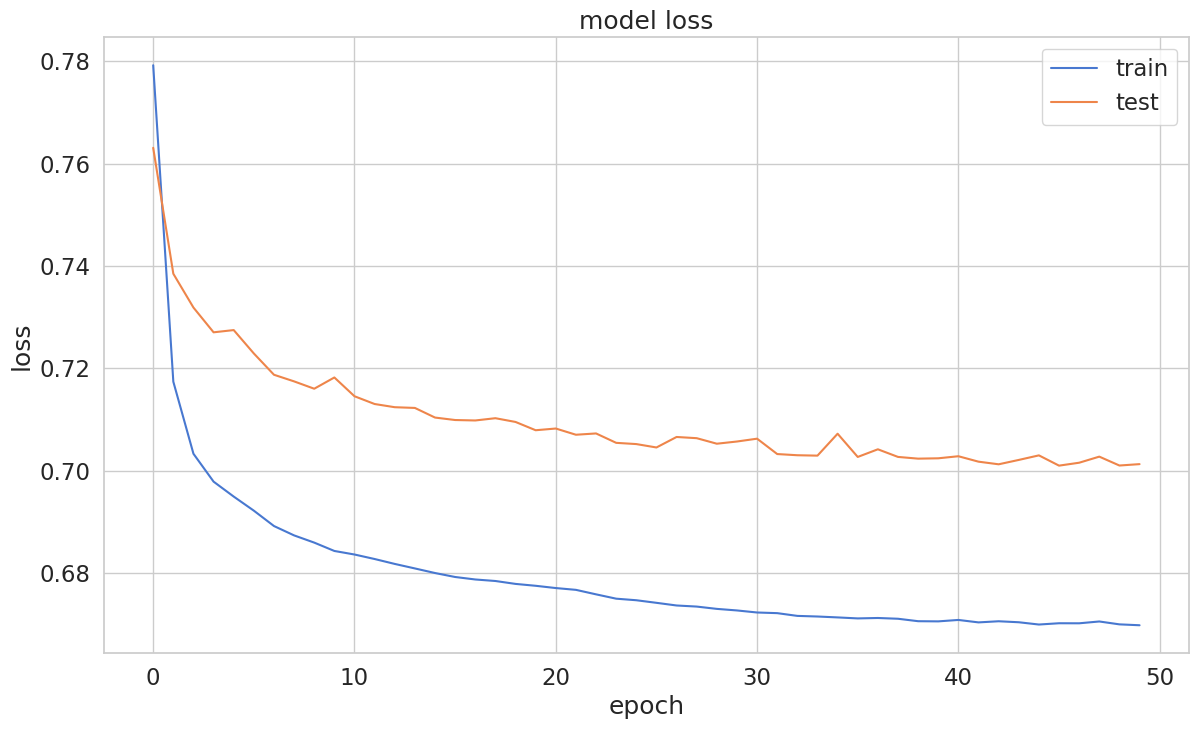

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(normal_test)
mse = np.mean(np.power(normal_test - predictions, 2), axis=1)
error_cf = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': fraud_test})
error_cf.describe()

2671/2671 [==============================] - 10s 4ms/step


,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.700089,0.001873
std,3.541824,0.043233
min,0.038664,0.000000
25%,0.222455,0.000000
50%,0.366492,0.000000
75%,0.592753,0.000000
max,375.635662,1.000000


In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

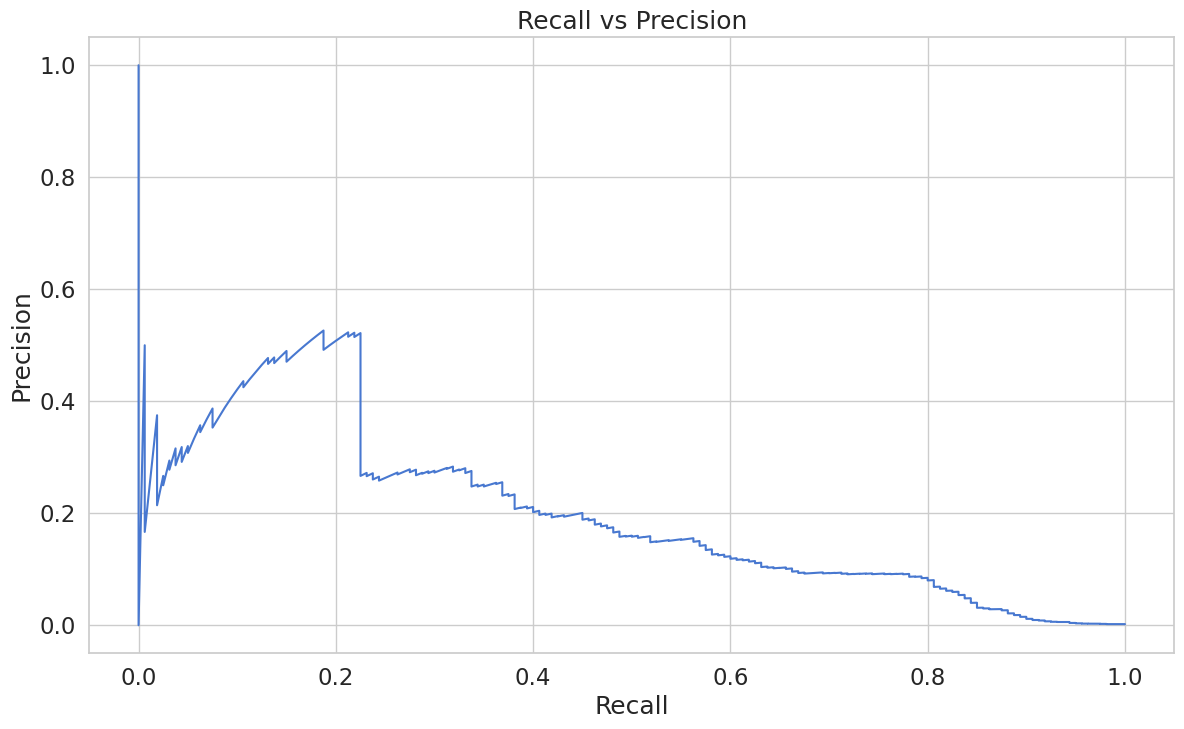

In [ ]:
precision, recall, th = precision_recall_curve(error_cf.true_class, error_cf.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

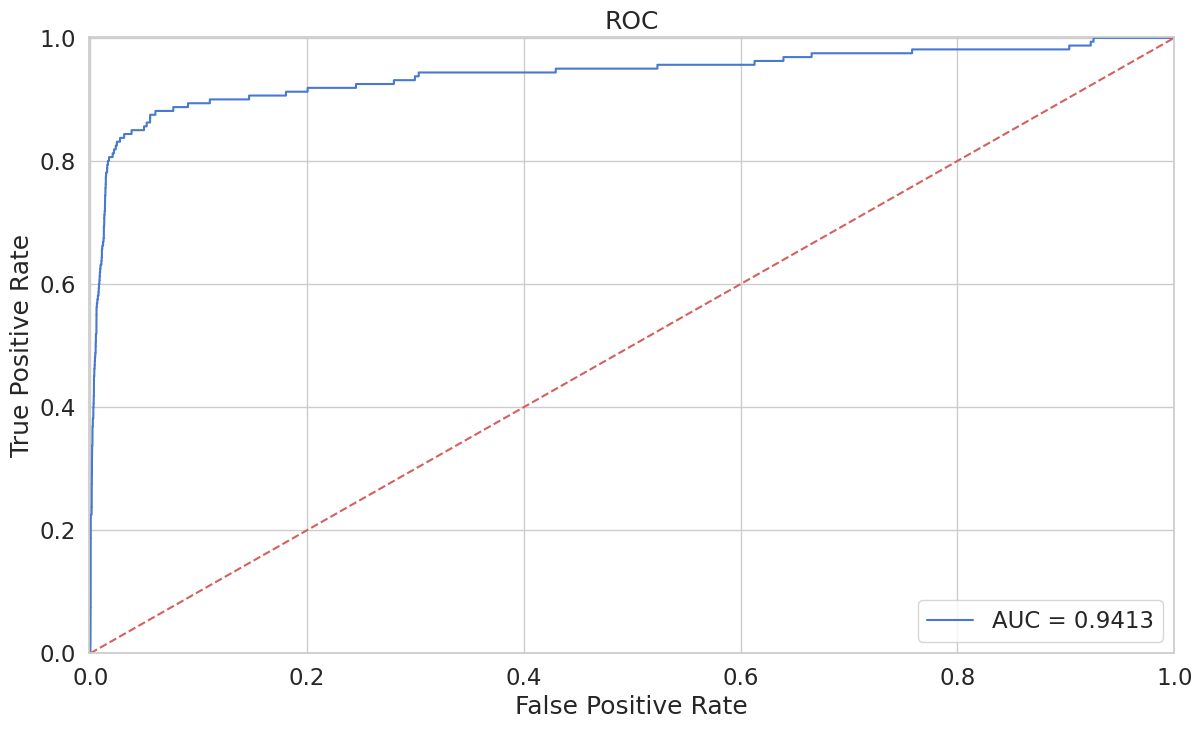

In [ ]:
fpr, tpr, thresholds = roc_curve(error_cf.true_class, error_cf.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

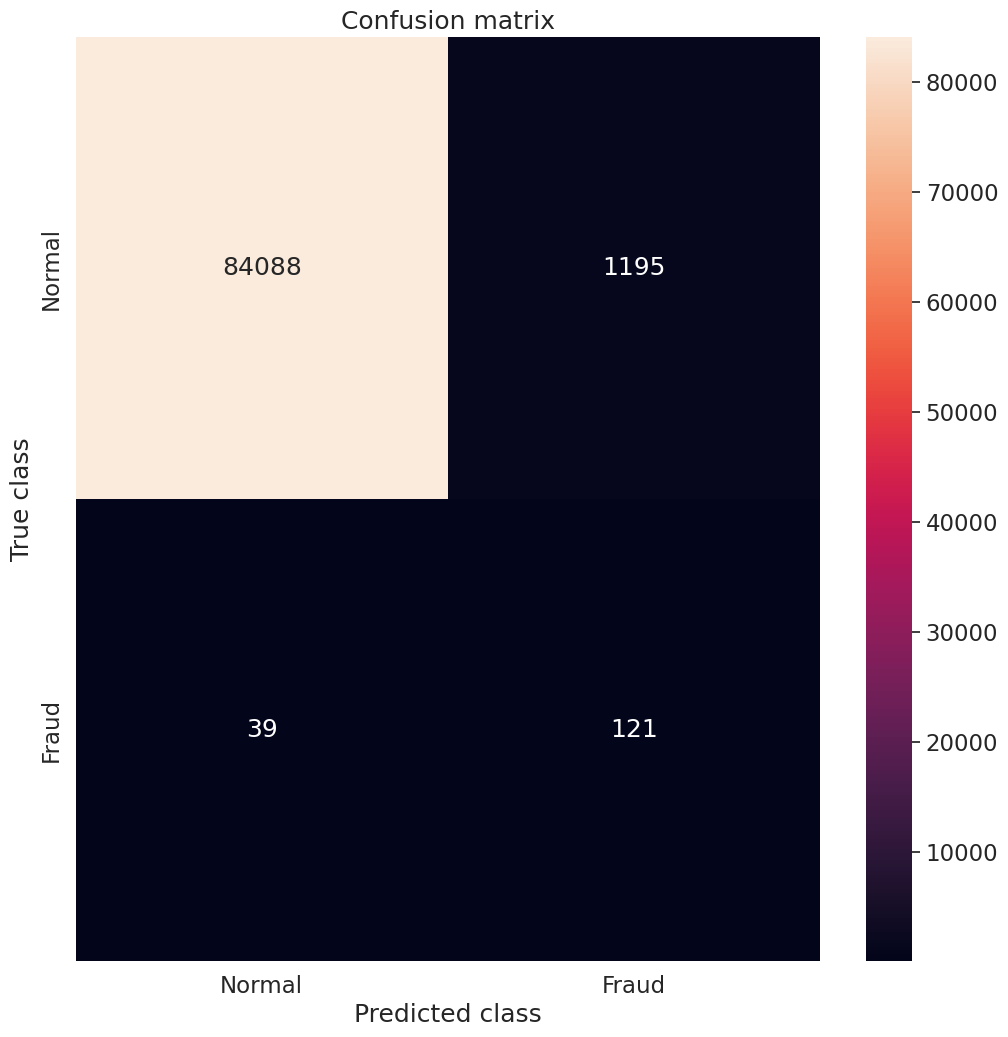

In [ ]:
threshold = 4
y_pred = [1 if e > threshold else 0 for e in error_cf.reconstruction_error.values]
conf_matrix = confusion_matrix(error_cf.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
# prompt: classification report code

print(classification_report(error_cf.true_class, y_pred, target_names=LABELS))


              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     85283
       Fraud       0.09      0.76      0.16       160

    accuracy                           0.99     85443
   macro avg       0.55      0.87      0.58     85443
weighted avg       1.00      0.99      0.99     85443

